# Label analysis

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns
import metalabeller as ml
import ta
import macdtester as t

In [2]:
df = dl.get_working_data("ATOMUSDT", span="h")

## Bars

### Size of bars

In [3]:
base = t.get_base_macd_events(df, mlen=3, stdev=1)

In [10]:
stats = ["bar_std", "bar_std1", "bar_std2", "bstd_7std"]

In [11]:
def bar_std(df, df1=None, df7=None, df30=None):
    heights = df.high-df.low
    return np.std(heights)
def bar_std1(df, df1, df7=None, df30=None):
    heights = df1.high-df1.low
    return np.std(heights)
def bar_std2(df, df1, df7, df30=None):
    heights = df7.high-df7.low
    return np.std(heights)

def bar_std_compare(df, df1, df7, df30):
    base = bar_std(df)
    new = bar_std(df7)
    return base/new

In [12]:
funcs = [bar_std, bar_std1, bar_std2, bar_std_compare]

In [13]:
events = t.get_macd_events(df, base, stats, funcs)

In [14]:
events.tail()

,bar_std,bar_std1,bar_std2,bstd_7std
t0,,,,
2021-10-12 22:00:00,0.614342,0.424084,0.358204,1.715062
2021-10-14 04:00:00,0.413658,0.448704,0.346303,1.194496
2021-10-20 22:00:00,0.279296,0.323046,0.283810,0.984095
2021-10-23 18:00:00,0.244187,0.216078,0.286183,0.853255
2021-10-26 20:00:00,0.494188,0.468594,0.341785,1.445904


verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works
mean: 0.6981%
median: 0.0%
0.0    87
1.0    46
Name: target, dtype: int64


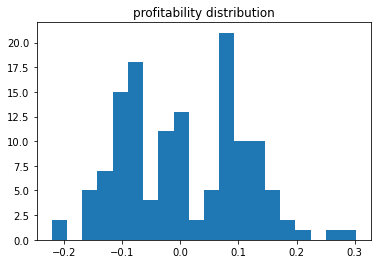

In [15]:
labels = t.get_labels(df, events, 3, base.set_index("t0").gain.reindex(events.index), tp=1, sl=1)

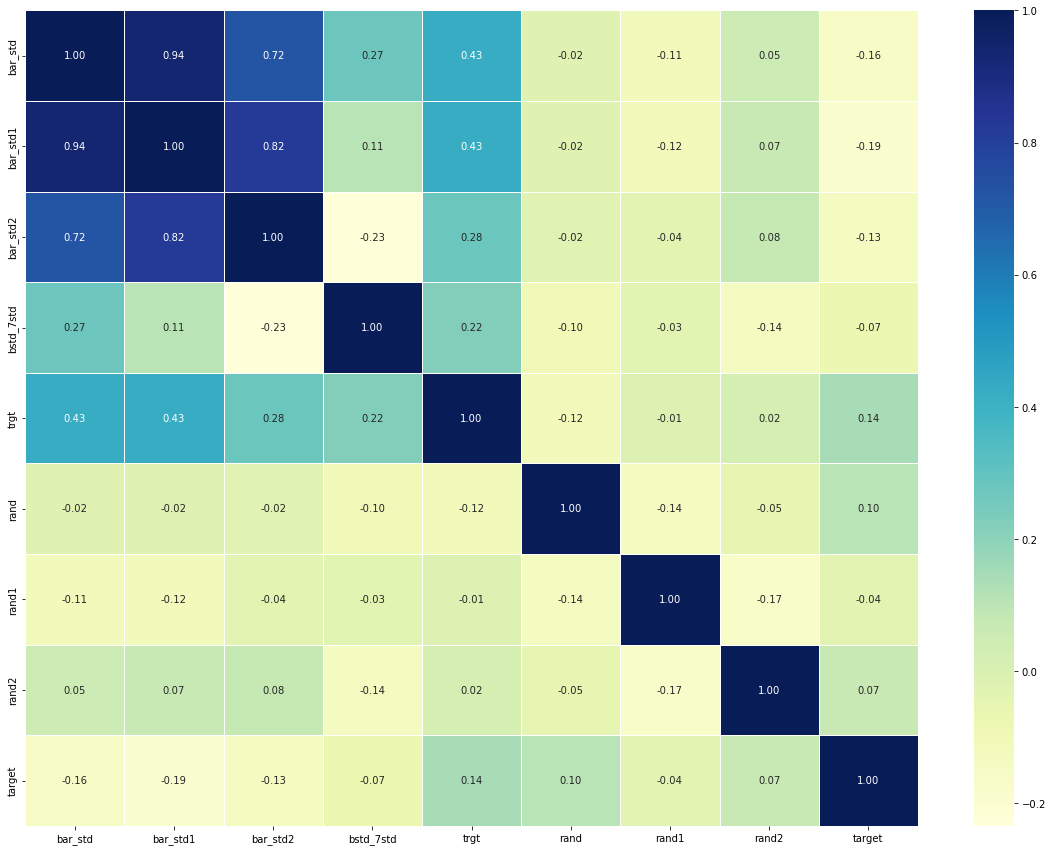

In [16]:
indicators = list(events.columns)
indicators.append("target")

# d = df[list(indicators)].copy()
d = events.copy()

d["rand"] = list(np.random.random(len(d)))
d["rand1"] = list(np.random.random(len(d)))
d["rand2"] = list(np.random.random(len(d)))

d["target"] = list(labels.ret)
d.drop(["t1"], axis=1, inplace=True)
d = d.astype(float)
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")